## Step 0: Pre-Requirements - Import Modules 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib
from statsmodels.tools.eval_measures import rmse 
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings 
warnings.filterwarnings("ignore")

Using matplotlib backend: agg


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Step 1 : Import data set and draw ACF / PACF plot then choose time lag

Download the data from https://github.com/Marimuthu8421/LSTM-Models/tree/main/data/India and store it in your local file. Run the below code and click 'Choose Files' then browse your data (.csv file).   

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving India -COVID-19 data_train.csv to India -COVID-19 data_train.csv


Import the uploaded data as name 'df' using the function pd.read_csv(). If you are using other data then please change 'UK covid19 train_data.csv' as data file name.

In [ ]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['India -COVID-19 data_train.csv']))
print(df.head())

        Date  Confirmed
0  01-Dec-21       9875
1  02-Dec-21       9191
2  03-Dec-21       9128
3  04-Dec-21       8912
4  05-Dec-21       8413


In [ ]:
# Month  is already in index of df otherwise change it usingthe following code
# change the Month column as Index

df1=df
df1.Date=pd.to_datetime(df.Date)
df1=df1.set_index("Date")
df1.head()

,Confirmed
Date,
2021-12-01,9875
2021-12-02,9191
2021-12-03,9128
2021-12-04,8912
2021-12-05,8413


Plot line graph for Daily cases using the code given below

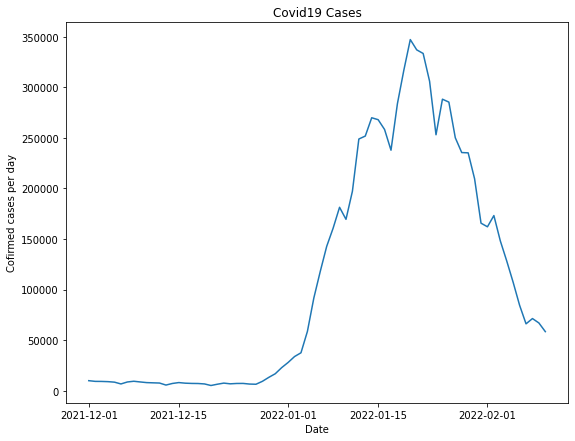

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(df1.index.values, df1['Confirmed'])
ax.set(xlabel="Date",
       ylabel="Cofirmed cases per day",
       title="Covid19 Cases")

plt.show()

Draw ACF / PACF plot using the function accf() / pacf(). Choose the significant lag as the optimal time step which can be used for data pre-processing.

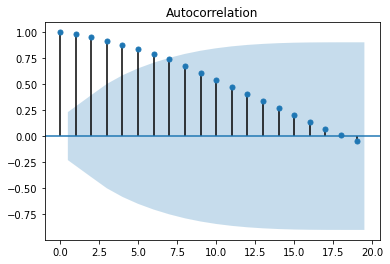

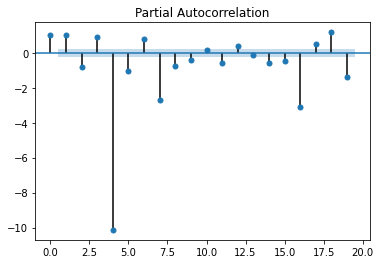

In [ ]:
## Auto correlation and Partial Auto correlation Plot
from statsmodels.graphics.tsaplots import acf, pacf, plot_pacf, plot_acf
from matplotlib import pyplot

import numpy as np
dat=np.array(df1['Confirmed'])

plot_acf(dat)
plot_pacf(dat)
pyplot.show()

## Step2: Data pre-processing

We can divide the sequence into input (X) and output (y).
Let {Xi, i=1, 2, 3, …, n} be the daily incident cases. Suppose, lag is three, then the fourth day count depends on previous 3 days (third, second and first) and fifth day count depends on fourth, third, and second day counts, and so on. Therefore, the data should be organized as follows:

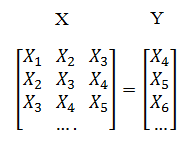

Define the function **prepare_data()** which convert the time series data into X and y.

In [ ]:
# preparing independent and dependent features
def split_sequence(sequence, n_step):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_step
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
n_step=6
# split into samples
X, y = split_sequence(df['Confirmed'], n_step)

In [ ]:
# Summarize the data
for i in range(len(X)):
  print(X[i], y[i])

[9875 9191 9128 8912 8413 6648] 8590
[9191 9128 8912 8413 6648 8590] 9303
[9128 8912 8413 6648 8590 9303] 8614
[8912 8413 6648 8590 9303 8614] 7971
[8413 6648 8590 9303 8614 7971] 7749
[6648 8590 9303 8614 7971 7749] 7545
[8590 9303 8614 7971 7749 7545] 5547
[9303 8614 7971 7749 7545 5547] 7114
[8614 7971 7749 7545 5547 7114] 7996
[7971 7749 7545 5547 7114 7996] 7403
[7749 7545 5547 7114 7996 7403] 7158
[7545 5547 7114 7996 7403 7158] 7079
[5547 7114 7996 7403 7158 7079] 6650
[7114 7996 7403 7158 7079 6650] 5105
[7996 7403 7158 7079 6650 5105] 6378
[7403 7158 7079 6650 5105 6378] 7470
[7158 7079 6650 5105 6378 7470] 6767
[7079 6650 5105 6378 7470 6767] 7116
[6650 5105 6378 7470 6767 7116] 7161
[5105 6378 7470 6767 7116 7161] 6538
[6378 7470 6767 7116 7161 6538] 6342
[7470 6767 7116 7161 6538 6342] 9236
[6767 7116 7161 6538 6342 9236] 13167
[ 7116  7161  6538  6342  9236 13167] 16727
[ 7161  6538  6342  9236 13167 16727] 22775
[ 6538  6342  9236 13167 16727 22775] 27878
[ 6342  9236 131

## Step 3: Reorganize the data as in the format of input to the model

CNN LSTM model has one more argument called ‘subsequence’. Split the lag into number of sequence and sub steps. And the sub-steps are multiple of the kernel size in the convolutional layer. For example, lag is six days then split the six into three subsequences and two sub-steps (3*2=6) and the kernel size of the convolutional layer must be two. The input shape of the CNN LSTM model is [samples, subsequences, sub-steps, features]

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
n_seq=3
n_steps=2
X = X.reshape((X.shape[0],  n_seq, n_steps, n_features))
print(X.shape)

(66, 3, 2, 1)


## Step 4: Model Buiilding

A CNN model can be used in a hybrid model with an LSTM backend where the CNN is used to interpret subsequences of input that together are provided as a sequence to an LSTM model to interpret. This hybrid model is called a CNN-LSTM.

Our CNN-LSTM model has one 1d-CNN layer followed by max-pooling layer and flatten layer.  Then two LSTM layers with 500 neurons followed by eight dense layers

However, the dense layers can be adjusted based on the model perfomance.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(1000, activation='relu',return_sequences=True,kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(LSTM(500, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))

#model.add(Dense(5000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
#model.add(Dense(3000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
#model.add(Dense(2000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(1000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(500, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(300, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(200, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(100, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(1))


In [ ]:
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 2, 64)      128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, None, 1000)        4260000   
                                                                 
 lstm_1 (LSTM)               (None, 500)               3002000   
                                                        

**Call backs**

**reuce lr (Learning Rate)**-if no  improvement seeing for the patience the learning rate is reuce.

**factor** - by which the learning eate will be reduce.

**patience** - # of epochs with no improvement after that the learning rate will reduce

**verbose** - contain binary 0 quit 1 update message.

**mode** - auto min max, 
    **min** - LR will reduce when quantity 
monitor has stop decresing;
    **max** -  LR will reduce when quantity monitor has stop incresing;
    **auto** - the direction is automatically infere from the nameof monitor. 

In [ ]:
# Call backs
# reuce lr (Learning Rate)-if no  improvement seeing for the patience the learning rate is reuce
# factor - by which the learning eate will be reduce
# patience - # of epochs with no improvement after that the learning rate will reduce
# verbose - contain binary 0 quit 1 update msg
# mode - auto min max, min - LR will reduce when quantity monitor has stop decresing
#         max -  LR will reduce when quantity monitor has stop incresing
#         auto - the direction is automatically infere from the nameof monitor
# Early stopping  

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

checkpoint=ModelCheckpoint(filepath='best_weights.hdf11', 
                           save_best_only=True, save_weights_only=True)
lr_reduce=ReduceLROnPlateau(monitor='loss',factor=0.3,
                            patience=3,  verbose=2, mode='max')
early_stop=EarlyStopping(monitor='loss',min_delta=0.1, patience=3, mode='min')

## Step 5: Fitting and evaluating the model

Fit a model using the train data and evaluate the performance. The Mean Squared Error (MSE) / Mean Absolute Error (MAE) can be used as the metrics to evaluate model performance of both train and test data. 

In [ ]:
# fit model

model.fit(X, y, epochs=100,batch_size=16, verbose=1,callbacks=[checkpoint,lr_reduce])

Epoch 1/100
5/5 [==============================] - 4s 189ms/step - loss: 129572724736.0000 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 1s 191ms/step - loss: 29673230336.0000 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 191ms/step - loss: 7072284672.0000 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 2197006336.0000WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
5/5 [==============================] - 1s 188ms/step - loss: 2197006336.0000 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 1s 183ms/step - loss: 1429788544.0000 - lr: 3.0000e-04
Epoch 6/100
5/5 [==============================] - 1s 186ms/step - loss: 1399016576.0000 - lr: 3.0000e-04
Epoch 7/100
5/5 [==============================] - ETA: 0s - loss: 1476014080.0000WARNING:tensorflow:Can save best model only with val_loss available, 

In [ ]:
# Predict
y_hat=model.predict(X, verbose=1)
print(y_hat)

3/3 [==============================] - 1s 42ms/step
[[  7109.144 ]
 [  7571.5854]
 [  8768.329 ]
 [  9552.569 ]
 [  7513.993 ]
 [  7275.0503]
 [  6663.262 ]
 [  6330.225 ]
 [  6085.998 ]
 [  6638.025 ]
 [  7635.116 ]
 [  6522.856 ]
 [  6389.6846]
 [  5819.3716]
 [  5648.3325]
 [  5415.4385]
 [  7111.5503]
 [  6980.001 ]
 [  6120.943 ]
 [  8229.115 ]
 [  6158.3506]
 [  5491.6255]
 [ 10080.418 ]
 [ 11728.336 ]
 [ 14302.89  ]
 [ 18329.771 ]
 [ 23332.947 ]
 [ 30628.822 ]
 [ 32013.879 ]
 [ 49690.094 ]
 [ 65579.74  ]
 [ 91551.5   ]
 [120337.625 ]
 [157945.22  ]
 [162134.75  ]
 [175035.34  ]
 [202062.77  ]
 [250918.47  ]
 [267974.53  ]
 [275891.94  ]
 [258799.08  ]
 [222233.12  ]
 [220787.2   ]
 [295053.62  ]
 [250472.39  ]
 [382686.94  ]
 [345591.75  ]
 [351764.88  ]
 [284413.16  ]
 [256827.58  ]
 [252003.4   ]
 [241081.62  ]
 [230924.8   ]
 [219561.47  ]
 [211151.23  ]
 [200088.75  ]
 [157968.2   ]
 [167736.9   ]
 [145701.36  ]
 [155217.9   ]
 [115229.695 ]
 [111577.46  ]
 [101301.97  ]
 [ 

In [ ]:
n_steps=6
df_pred=pd.DataFrame.from_records(y_hat, columns=['Predicted'])
df_pred=df_pred.reset_index(drop=True)


df_actual= pd.DataFrame(dat[n_steps:len(dat)], columns=['Actual'])
df_actual=df_actual.reset_index(drop=True)
print(df_actual)

Date=df.iloc[n_steps:,0]
Date=Date.reset_index(drop=True)

data=pd.concat ([Date,df_actual,df_pred],axis=1)
print(type(data))
print(data.shape)
print(data)

    Actual
0     8590
1     9303
2     8614
3     7971
4     7749
..     ...
61   84391
62   66063
63   71274
64   66924
65   58350

[66 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
(66, 3)
         Date  Actual      Predicted
0  2021-12-07    8590    7109.144043
1  2021-12-08    9303    7571.585449
2  2021-12-09    8614    8768.329102
3  2021-12-10    7971    9552.569336
4  2021-12-11    7749    7513.993164
..        ...     ...            ...
61 2022-02-06   84391  111577.460938
62 2022-02-07   66063  101301.968750
63 2022-02-08   71274   90452.046875
64 2022-02-09   66924   76780.210938
65 2022-02-10   58350   62003.117188

[66 rows x 3 columns]


**Evaluation Metrics for traning data set.**

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

R2=r2_score(df_actual, df_pred)
print('R Squared: ', R2)

mae=mean_absolute_error(df_actual, df_pred)
print('Mean Absolute Error: ', mae)

mse=mean_squared_error(df_actual, df_pred)
print('Mean Squared Error: ', mse)

R Squared:  0.9538050239874543
Mean Absolute Error:  15027.581764914772
Mean Squared Error:  597315776.3103397


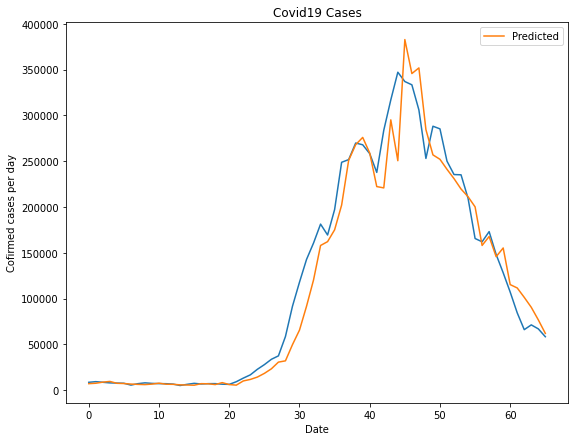

In [ ]:
#data=data.set_index('Date')
#print(data)

fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(data.index.values, data['Actual'])
data.Predicted.plot(ax=ax)
ax.set(xlabel="Date",
       ylabel="Cofirmed cases per day",
       title="Covid19 Cases")
plt.legend()
plt.show()

In [ ]:
import datetime
from datetime import datetime, timedelta, date
last_date=df.iloc[-1,0]

# Future Prediction
#print(X_input.shape)
#print(X_input)

predictions=model.predict(X,verbose=1)
future_time_steps=15
x1=X[-1:,:,:,:] # Last input
x1=x1.astype('float64')

p1=predictions[-1:]  # take last output

for i  in range(future_time_steps):
  
  x2=np.array([[x1[0][0][1][0], x1[0][1][0][0], x1[0][1][1][0],x1[0][2][0][0], x1[0][2][1][0],  p1]] ,dtype=np.float)  
  #print('X2 is', x2)
  x3=x2.reshape((1,3,2,1))
  
  p2=model.predict(x3, verbose=1)
  predictions=np.append(predictions, p2)
  x1=x3
  p1=p2
 
yhat=predictions
yhat=np.reshape(yhat, (-1,1))

df_pred=pd.DataFrame.from_records(yhat, columns=['Predicted'])
df_pred=df_pred.reset_index(drop=True)

df_actual=df[n_steps:len(df)]
df_actual=df_actual.reset_index(drop=True)

In [ ]:
Predicted_data=pd.concat ([df_actual,df_pred],axis=1)

print(type(Predicted_data))
print(Predicted_data.shape)
print(Predicted_data)

<class 'pandas.core.frame.DataFrame'>
(81, 4)
         Date  Confirmed  Total Confirmed     Predicted
0  2021-12-07     8590.0       34657114.0   7109.144043
1  2021-12-08     9303.0       34666417.0   7571.585449
2  2021-12-09     8614.0       34675031.0   8768.329102
3  2021-12-10     7971.0       34683002.0   9552.569336
4  2021-12-11     7749.0       34690751.0   7513.993164
..        ...        ...              ...           ...
76        NaT        NaN              NaN  23243.773438
77        NaT        NaN              NaN  19639.296875
78        NaT        NaN              NaN  22668.574219
79        NaT        NaN              NaN  17453.427734
80        NaT        NaN              NaN  17343.804688

[81 rows x 4 columns]


## Step 7: Download the data

Write the Predicted data as .csv file and download it  for future purpose

In [ ]:
from google.colab import files
Predicted_data.to_csv('TN -COVID-19 Prediction -CNN LSTM 17Feb22.csv') 
files.download('TN -COVID-19 Prediction -CNN LSTM 17Feb22.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>